In [30]:


import sys 
sys.path.append("../")

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import umap
import sklearn
import pandas as pd 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import catboost as cb 
from core.utils import (find_non_numerical_columns,categorize_columns,evaluate_cross_validation,
                   convert_df_to_numeric_df,scale_columns,evaluate_model)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
df = pd.read_csv("../data/assignement_with_bert_sentiments")
target = df["Exited"]
numerical_df = convert_df_to_numeric_df(df,["RowNumber", "CustomerId", "Surname","CustomerFeedback","Exited"])
numerical_df["RatioSalary"] = numerical_df["EstimatedSalary"] /  (numerical_df["Balance (EUR)"]+1)
numerical_df["RatioProducst"] = numerical_df["NumberOfProducts"] / (numerical_df["Tenure"] +1)
numerical_df["RatioCards"] = numerical_df["HasCreditCard"] &  numerical_df["IsActiveMember"]
numerical_df["ProductSalary"] = numerical_df["Balance (EUR)"] *  numerical_df["CreditScore"]



scaled_df = scale_columns(numerical_df,columns=["EstimatedSalary","Balance (EUR)","CreditScore","Age","Tenure","RatioSalary",
                                    "RatioProducst","RatioCards","ProductSalary"])

In [34]:
scaled_df = scaled_df.reset_index(drop=True).drop(columns=["Unnamed: 0"])

In [35]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(scaled_df, target.values, test_size=0.2, random_state=0, stratify=target.values)

In [42]:
params = {
    'depth': hp.choice('max_depth', np.arange(2, 12, dtype=int)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', 1, 10),
    'iterations': hp.choice('iterations', np.arange(50, 150,  dtype=int)),
    'learning_rate':  hp.uniform('learning_rate', 0.001, 0.1),
    "verbose":0
}

def objective_xgb_note(params):
    cat_model = cb.CatBoostClassifier(**params,loss_function='Logloss', eval_metric='AUC') 
    #cat_model = xgb.XGBClassifier(**params,tree_method="gpu_hist", enable_categorical=True)
    cat_model.fit(X_train, y_train)
    score = evaluate_model(X_test, y_test,cat_model,verbose=False)
    return {'loss': -score, 'status': STATUS_OK}

best_params = fmin(objective_xgb_note, params, algo=tpe.suggest, max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:13<00:00,  1.32s/trial, best loss: -0.7268678539864981]


In [37]:
print("Best set of hyperparameters: ", best_params)

Best set of hyperparameters:  {'iterations': 96, 'l2_leaf_reg': 11.110546970137204, 'learning_rate': 0.04572137694596289, 'max_depth': 8}


In [38]:
cat_model = cb.CatBoostClassifier(**best_params)

In [39]:
cat_model.fit(X_train, y_train)

0:	learn: 0.6711002	total: 10.9ms	remaining: 1.04s
1:	learn: 0.6530851	total: 23ms	remaining: 1.08s
2:	learn: 0.6365044	total: 35ms	remaining: 1.08s
3:	learn: 0.6176277	total: 41.9ms	remaining: 964ms
4:	learn: 0.6007868	total: 52.5ms	remaining: 956ms
5:	learn: 0.5869072	total: 65.1ms	remaining: 976ms
6:	learn: 0.5726073	total: 76.5ms	remaining: 973ms
7:	learn: 0.5582706	total: 88.1ms	remaining: 969ms
8:	learn: 0.5470939	total: 102ms	remaining: 984ms
9:	learn: 0.5353339	total: 114ms	remaining: 983ms
10:	learn: 0.5250818	total: 124ms	remaining: 961ms
11:	learn: 0.5148776	total: 135ms	remaining: 946ms
12:	learn: 0.5045651	total: 146ms	remaining: 931ms
13:	learn: 0.4959275	total: 157ms	remaining: 921ms
14:	learn: 0.4871624	total: 165ms	remaining: 892ms
15:	learn: 0.4796656	total: 177ms	remaining: 884ms
16:	learn: 0.4720708	total: 188ms	remaining: 872ms
17:	learn: 0.4652788	total: 198ms	remaining: 859ms
18:	learn: 0.4580460	total: 206ms	remaining: 833ms
19:	learn: 0.4512020	total: 211ms	rem

 balanced accuracy is 0.7269488286437439
 AUC is 0.7269488286437439


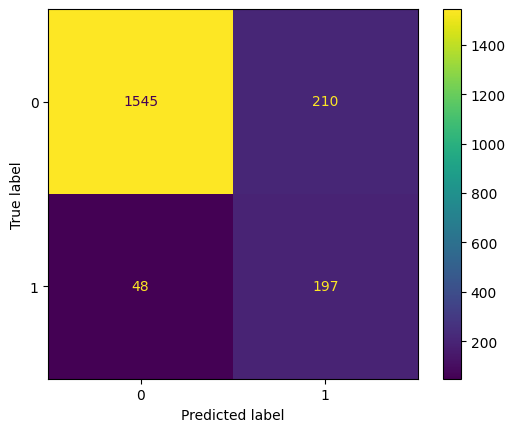

In [40]:
score = evaluate_model(X_test, y_test,cat_model,verbose=True)

In [41]:
acc = evaluate_cross_validation(scaled_df,cat_model,target.values,cv=5,test_size=0.2)
print(f"Average cross validation accuracy is {np.mean(acc)}")

0:	learn: 0.6711628	total: 11.8ms	remaining: 1.12s
1:	learn: 0.6517576	total: 25ms	remaining: 1.17s
2:	learn: 0.6352378	total: 36.4ms	remaining: 1.13s
3:	learn: 0.6165154	total: 44.7ms	remaining: 1.03s
4:	learn: 0.6001864	total: 57.3ms	remaining: 1.04s
5:	learn: 0.5859812	total: 68.3ms	remaining: 1.02s
6:	learn: 0.5717505	total: 78.6ms	remaining: 1000ms
7:	learn: 0.5574741	total: 88.8ms	remaining: 976ms
8:	learn: 0.5463755	total: 102ms	remaining: 989ms
9:	learn: 0.5346802	total: 114ms	remaining: 978ms
10:	learn: 0.5243153	total: 126ms	remaining: 975ms
11:	learn: 0.5146806	total: 137ms	remaining: 960ms
12:	learn: 0.5038426	total: 149ms	remaining: 953ms
13:	learn: 0.4951114	total: 161ms	remaining: 945ms
14:	learn: 0.4865099	total: 169ms	remaining: 913ms
15:	learn: 0.4796727	total: 182ms	remaining: 908ms
16:	learn: 0.4721748	total: 195ms	remaining: 908ms
17:	learn: 0.4644799	total: 210ms	remaining: 909ms
18:	learn: 0.4569341	total: 225ms	remaining: 912ms
19:	learn: 0.4502010	total: 236ms	